# Introducing Pandas UDF for PySpark

### How to run your native Python code with PySpark, fast.

From blog post [here](https://databricks.com/blog/2017/10/30/introducing-vectorized-udfs-for-pyspark.html). 
Notebook [here](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1281142885375883/2174302049319883/7729323681064935/latest.html)

In [21]:
from pyspark import SparkConf
from pyspark.sql import SparkSession, Row

from pyspark.sql.types import *
from pyspark.sql.functions import col, count, rand, collect_list, explode, struct, count, lit
from pyspark.sql.functions import pandas_udf, PandasUDFType, udf

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
conf = SparkConf().setAppName('pandas_udf').setMaster('local[*]').set('spark.driver.memory', '1g').set('spark.executor.memory', '2g')
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

In [3]:
df = spark.range(0, 10 * 1000 * 1000).withColumn('id', (col('id') / 10000).cast('integer')).withColumn('v', rand())
df.cache()
print(df.count())
df.show(10)

10000000
+---+--------------------+
| id|                   v|
+---+--------------------+
|  0| 0.22692148922641953|
|  0|  0.8870604758495169|
|  0|  0.8196935133622535|
|  0|  0.8839905027549613|
|  0| 0.37285424420874225|
|  0|  0.7628067085730941|
|  0|  0.6881444107531646|
|  0| 0.35952900189067527|
|  0|0.052865813985299215|
|  0|  0.9586827215607796|
+---+--------------------+
only showing top 10 rows



## Plus One

First, let's define row-at-a-time UDFs

In [4]:
# Use udf to define a row-at-a-time udf
@udf('double')

# Input/output are both a single double value
def plus_one(v):
      return v + 1

In [5]:
%timeit df.withColumn('v', plus_one(df.v)).agg(count(col('v'))).show()

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

11.1 s ± 1.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now let's use the very new Pandas UDFs.

Note that there are two important requirements when using scalar pandas UDFs:

* The input and output series must have the same size.
* How a column is split into multiple pandas.Series is internal to Spark, and therefore the result of user-defined function must be independent of the splitting.

In [6]:
# Use pandas_udf to define a Pandas UDF
@pandas_udf('double', PandasUDFType.SCALAR)
# Input/output are both a pandas.Series of doubles

def pandas_plus_one(v):
    return v + 1

In [7]:
%timeit df.withColumn('v', pandas_plus_one(df.v)).agg(count(col('v'))).show()

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

8.62 s ± 1.14 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


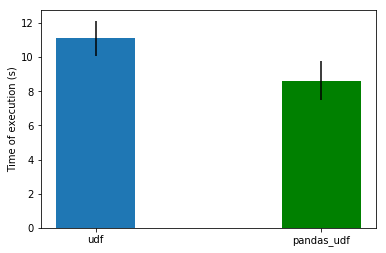

In [32]:
means = (11.1, 8.62)
stds = (1.03, 1.14)

ind = np.arange(2)

udf, pandas_udf = plt.bar(ind, means, width=0.35, yerr=stds)
plt.ylabel('Time of execution (s)')
plt.xticks(ind, ('udf', 'pandas_udf'))
pandas_udf.set_facecolor('g')

## Cumulative probability

In [8]:
@udf('double')
def cdf(v):
    return float(stats.norm.cdf(v))

In [9]:
%timeit df.withColumn('cumulative_probability', cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|c

In [10]:
@pandas_udf('double')
def pandas_cdf(v):
    return pd.Series(stats.norm.cdf(v))

In [11]:
%timeit df.withColumn('cumulative_probability', pandas_cdf(df.v)).agg(count(col('cumulative_probability'))).show()

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|count(cumulative_probability)|
+-----------------------------+
|                     10000000|
+-----------------------------+

+-----------------------------+
|c

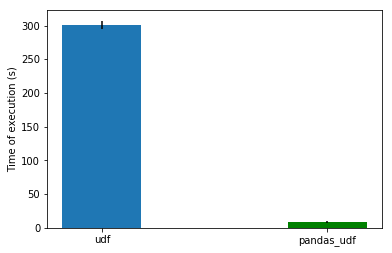

In [33]:
means = (60 * 5 + 1, 8.38)
stds = (5.96, 1.76)

ind = np.arange(2)

udf, pandas_udf = plt.bar(ind, means, width=0.35, yerr=stds)
plt.ylabel('Time of execution (s)')
plt.xticks(ind, ('udf', 'pandas_udf'))
pandas_udf.set_facecolor('g')

## Grouped Map Pandas UDFs

This example shows a simple use of grouped map Pandas UDFs: subtracting mean from each value in the group.

In [12]:
@udf(ArrayType(df.schema))
def substract_mean(rows):
    vs = pd.Series([r.v for r in rows])
    vs = vs - vs.mean()
    return [Row(id=rows[i]['id'], v=float(vs[i])) for i in range(len(rows))]

In [13]:
%timeit df.groupby('id').agg(collect_list(struct(df['id'], df['v'])).alias('rows')).withColumn('new_rows', substract_mean(col('rows'))).withColumn('new_row', explode(col('new_rows'))).withColumn('id', col('new_row.id')).withColumn('v', col('new_row.v')).agg(count(col('v'))).show()

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

4min 45s ± 3.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
@pandas_udf(df.schema, PandasUDFType.GROUPED_MAP)
# Input/output are both a pandas.DataFrame
def pandas_subtract_mean(pdf):
    return pdf.assign(v=pdf.v - pdf.v.mean())

In [15]:
%timeit df.groupby('id').apply(pandas_subtract_mean).agg(count(col('v'))).show()

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

+--------+
|count(v)|
+--------+
|10000000|
+--------+

3min 43s ± 1.72 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


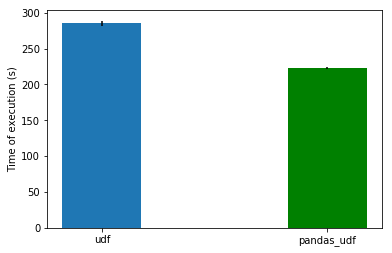

In [34]:
means = (60 * 4 + 45, 60 * 3 + 43)
stds = (3.61, 1.72)

ind = np.arange(2)

udf, pandas_udf = plt.bar(ind, means, width=0.35, yerr=stds)
plt.ylabel('Time of execution (s)')
plt.xticks(ind, ('udf', 'pandas_udf'))
pandas_udf.set_facecolor('g')

## Going further : PySpark Usage Guide for Pandas with Apache Arrow

There is a [link](https://spark.apache.org/docs/2.3.0/sql-programming-guide.html#pyspark-usage-guide-for-pandas-with-apache-arrow) in the documentation about this.